# Light Curve Plot and Curve Fit

In [1]:
%matplotlib notebook

In [42]:
# Special import to allow PGF (for LaTeX) output while still showing
# interactive plots
# https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/
# https://matplotlib.org/tutorials/text/pgf.html
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'sans-serif',
#    "font.serif": [],
#    "font.sans-serif": ["DejaVu Sans"],
    'text.usetex': True,
    'pgf.rcfonts': False,
#    'pgf.preamble': ["\\usepackage{cmbright}"]
    'text.latex.preamble': [r'\usepackage{cmbright}', 
                            r'\usepackage{amsmath}']
                        #    r'\setmainfont{helvetica}']

})

#import tikzplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from astropy.timeseries import TimeSeries, BinnedTimeSeries, aggregate_downsample
from astropy import units as u
from astropy.time import Time
from datetime import datetime
from dateutil import tz
from lmfit import Model
from lmfit.models import GaussianModel, ConstantModel
import csv

# Links:
#   https://docs.astropy.org/en/stable/api/astropy.time.TimePlotDate.html

x = []
y = []
y_error = []

with open('Measurements_with_GregMDT.csv') as f:
    reader = csv.DictReader(f, delimiter=',')
    for row in reader:
        x.append(float(row['JD_UTC']))
        y.append(float(row['Source_AMag_T1']))
        y_error.append(float(row['Source_AMag_Err_T1']))

# Convert our dates
x_datetime = Time(x, format='jd', scale='utc')

In [43]:
ts = TimeSeries(time=x_datetime)
# Add data
ts['mag'] = y * u.mag
ts['err'] = y_error
#print(ts)

# Convert to binned time series with 1 minute bin size
bts = aggregate_downsample(ts, time_bin_size=1*u.min, aggregate_func=np.nanmedian)

#print(bts)

/home/sanelson/.local/lib/python3.8/site-packages/lmfit/models.py:60: RuntimeWarning: invalid value encountered in greater
  halfmax_vals = np.where(y > (maxy+miny)/2.0)[0]


<IPython.core.display.Javascript object>


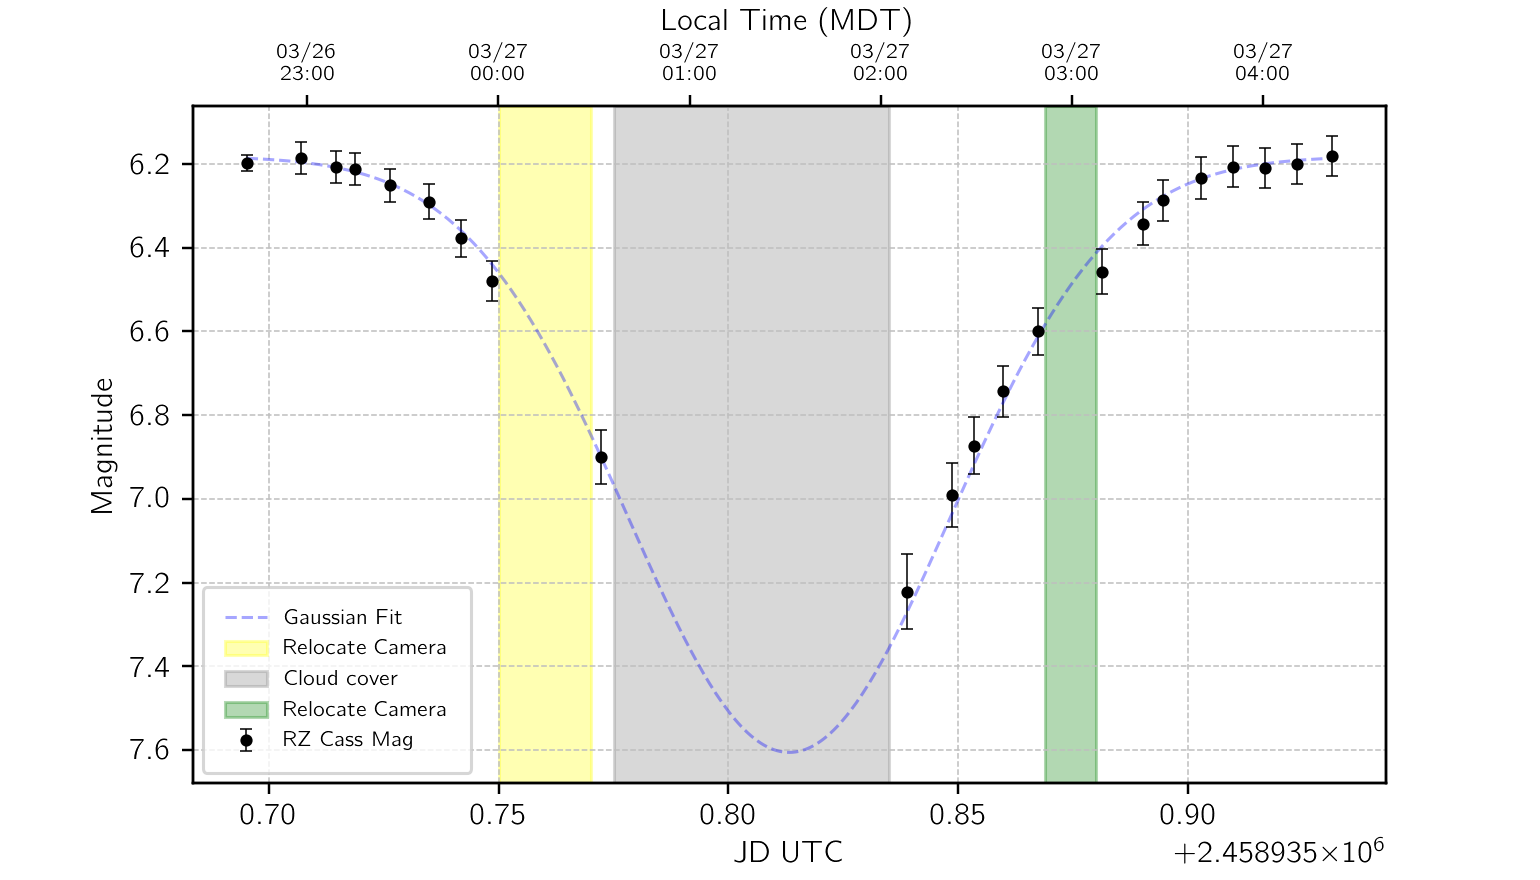

In [53]:
xval = np.array(bts.time_bin_start.jd)
yval = np.array(bts['mag'])
err = np.array(bts['err'])

# From: https://lmfit.github.io/lmfit-py/builtin_models.html
# and: https://stackoverflow.com/questions/44573896/python-fit-gaussian-to-noisy-data-with-lmfit
g_peak = GaussianModel()
g_offset = ConstantModel()
g_model = g_peak + g_offset
g_pars = g_offset.make_params(c=np.nanmin(yval))
g_pars += g_peak.guess(yval, x=xval,
                   center=np.median(xval),
                   amplitude=.125,
                   sigma=.035)
g_result = g_model.fit(yval, g_pars, x=xval, 
                   nan_policy='propagate')
#print(g_result.fit_report())
plt.figure(figsize=(7,4))
#plt.yticks(fontname = "DejaVu Sans")

# Plot Gaussian fit
plt.plot(xval, g_result.best_fit, 'b--', 
         linewidth=1, alpha=.35,
         label='Gaussian Fit')


# Plot data
plt.errorbar(xval, yval, yerr=err, marker=".", 
             linestyle='', elinewidth=0.5, 
             capsize=2, capthick=0.5, 
             color='black',
             label='RZ Cass Mag')

plt.xlabel('JD UTC')
plt.ylabel('Magnitude')
#plt.title('RZ Cassiopeiae\nPrimary Eclipse')
#plt.title('RZ Cassiopeiae Eclipse', size=20)


ax = plt.gca()

# Indicate first camera relocation
ax.axvspan(2458935.75,2458935.77, alpha=.3, color='yellow', label='Relocate Camera')

# Indicate cloud cover time period
ax.axvspan(2458935.775,2458935.835, alpha=.3, color='grey', label='Cloud cover')

# Indicate second camera relocation
ax.axvspan(2458935.869,2458935.88, alpha=.3, color='green', label='Relocate Camera')

# Set up secondary x axis for local time (MDT)
ax2 = ax.twiny()
formatter = DateFormatter("%m/%d\n%H:%M",tz=tz.gettz('MDT'))
ax2.plot_date(x_datetime.plot_date,y,xdate=True,alpha=0)
ax2.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_tick_params(rotation=0, labelsize=7)
ax2.set_xlabel('Local Time (MDT)')

ax.grid(which='major', axis='both', linestyle="--", linewidth=0.5, color='.75')
#plt.legend(prop={'size':50})
#ax.legend(loc='upper left', borderpad=2)
ax.legend(frameon=True, loc='lower left', borderpad=1, prop={'size':7})
ax.invert_yaxis()

plt.show()

plt.savefig("RZCas_light_curve.png", bbox_inches='tight', dpi=600)
plt.savefig("RZCas_light_curve.pdf", bbox_inches='tight')

# PGF format for use with LaTeX
plt.savefig("RZCas_light_curve.pgf", bbox_inches='tight')

# Output PGFplots code for LaTeX
#tikzplotlib.clean_figure()  # simplify and cleanup figure
#tikzplotlib.save("RZCas_light_curve.tex")
